<a href="https://colab.research.google.com/github/Ankita5051/Deep-learning-projects/blob/main/Sentiment_classification_using_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# sentiment classification using Transformer Models

In [ ]:
!pip install datasets

In [ ]:
!pip install torchinfo
from torchinfo import summary


In [ ]:
# Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim

from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import OneHotEncoder
import nltk
import re
import string
import numpy as np

import math
import matplotlib.pyplot as plt

from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report


nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load the SST2 dataset from torchtext.datasets for the fine grained sentiment classification task
(train and test splits). Show some samples from the dataset and corresponding class labels.
Preprocess the dataset to perform the following:
○ Removing stopwords  
○ Removing punctuations   
○ Tokenization (using BERT Tokenizer)  
○ Converting text tokens to numerical data (using torchtext.vocab)  
○ One hot encoding of labels  

In [ ]:
# Load dataset
dataset = load_dataset("sst2")
train_data = dataset["train"]
test_data = dataset["test"]
val_data = dataset["validation"]

# Show samples
print("Train Sample:", train_data[1000])
print("Test Sample:", test_data[0])
print("Validation Sample:", val_data[0])


Train Sample: {'idx': 1000, 'sentence': 'suspense , intriguing characters and bizarre bank robberies , ', 'label': 1}
Test Sample: {'idx': 0, 'sentence': 'uneasy mishmash of styles and genres .', 'label': -1}
Validation Sample: {'idx': 0, 'sentence': "it 's a charming and often affecting journey . ", 'label': 1}


In [ ]:
# Constants
MAX_LEN = 64
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
stop_words = set(stopwords.words('english'))

# Preprocessing Function
def preprocess(text):
  text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
  return " ".join([word for word in text.split() if word not in stop_words])

# Explicit label mapping (handle -1 in test set)
def fix_labels(labels):
  return [0 if lbl in [-1, 0] else 1 for lbl in labels]  # Map both -1 and 0 to 0

# Initialize OneHotEncoder with known categories
onehot = OneHotEncoder(categories=[[0, 1]], sparse_output=False)

# Force fit on all possible classes
dummy_labels = np.array([[0], [1]])
onehot.fit(dummy_labels)

class SST2Dataset(Dataset):
  def __init__(self, data, encoder):
    self.texts = [preprocess(d['sentence']) for d in data]
    self.raw_labels = [d['label'] for d in data]
    self.labels = torch.tensor(fix_labels(self.raw_labels))

    # BERT Tokenization
    encoding = tokenizer(
        self.texts,
        padding='max_length',
        truncation=True,
        max_length=MAX_LEN,
        return_tensors='pt'
    )

    self.input_ids = encoding['input_ids']
    self.attention_mask = encoding['attention_mask']

    # One-hot encode labels
    labels_oh = encoder.transform(np.array(self.labels).reshape(-1, 1))
    self.labels_oh = torch.tensor(labels_oh).float()

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return {
        'input_ids': self.input_ids[idx],
        'attention_mask': self.attention_mask[idx],
        'label': self.labels_oh[idx]
    }

# Create datasets
train_dataset = SST2Dataset(train_data, onehot)
test_dataset = SST2Dataset(test_data, onehot)
val_dataset = SST2Dataset(val_data, onehot)

# Data Loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


print("\nSample Preprocessed Text:")
print(f"Original: {train_data[1000]['sentence']}")
print(f"Processed: {train_dataset.texts[1000]}")


Sample Preprocessed Text:
Original: suspense , intriguing characters and bizarre bank robberies , 
Processed: suspense intriguing characters bizarre bank robberies


Split the train split into training and validation partitions and show the label distribution on the
training set.   

Traning Dataset size: 67349
Test Dataset size: 1821
Validation Dataset size: 872


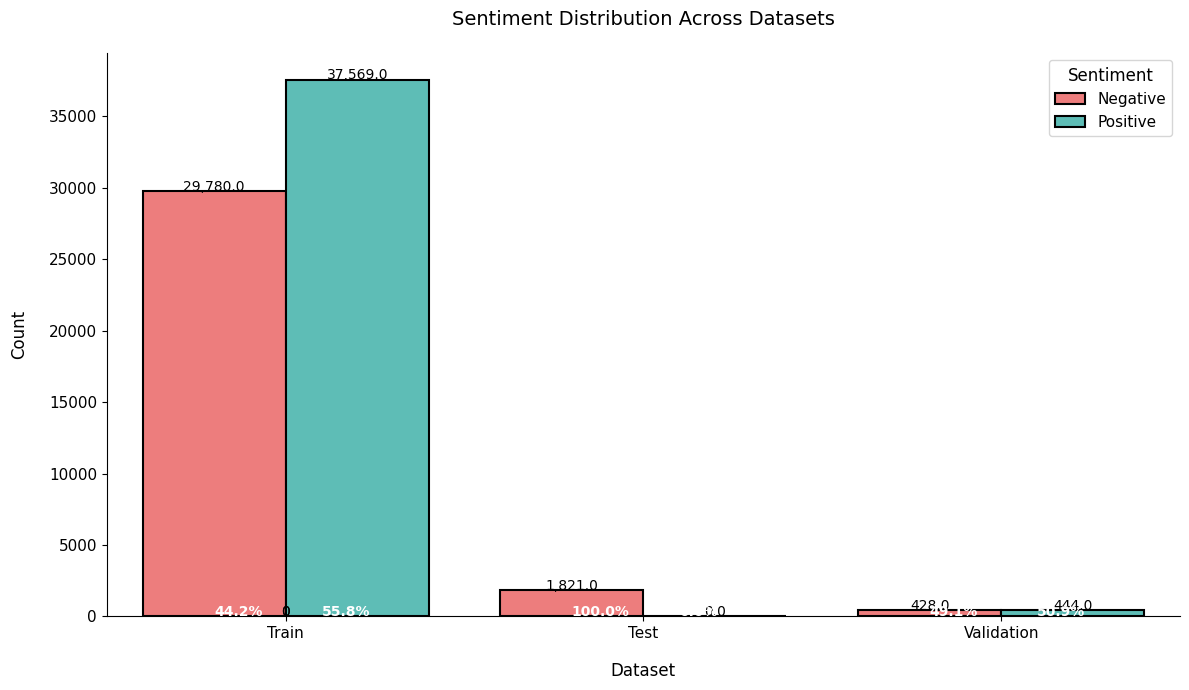

In [ ]:
print("Traning Dataset size:",len(train_data))
print("Test Dataset size:",len(test_data))
print("Validation Dataset size:",len(val_data))

# Get label counts for all datasets
def get_label_counts(dataset):
  labels = dataset.labels.numpy()
  return {
      'Negative': np.sum(labels == 0),
      'Positive': np.sum(labels == 1)
  }

counts = {
  'Train': get_label_counts(train_dataset),
  'Test': get_label_counts(test_dataset),
  'Validation': get_label_counts(val_dataset)
}

# Create melted DataFrame for visualization
df = pd.DataFrame({
    'Dataset': ['Train']*2 + ['Test']*2 + ['Validation']*2,
    'Sentiment': ['Negative', 'Positive']*3,
    'Count': [
      counts['Train']['Negative'], counts['Train']['Positive'],
      counts['Test']['Negative'], counts['Test']['Positive'],
      counts['Validation']['Negative'], counts['Validation']['Positive']
  ]
})

# Custom color palette
palette = {'Negative': '#FF6B6B', 'Positive': '#4ECDC4'}

# Create figure
plt.figure(figsize=(12, 7))
ax = sns.barplot(
  x='Dataset',
  y='Count',
  hue='Sentiment',
  data=df,
  palette=palette,
  edgecolor='black',
  linewidth=1.5
)

# Add annotations and styling
for p in ax.patches:
  height = p.get_height()
  ax.text(
    p.get_x() + p.get_width()/2.,
    height + 20,
    f'{height:,}',
    ha='center',
    fontsize=10,
    color='black'
  )

plt.title('Sentiment Distribution Across Datasets', fontsize=14, pad=20)
plt.xlabel('Dataset', fontsize=12, labelpad=15)
plt.ylabel('Count', fontsize=12, labelpad=15)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title='Sentiment', title_fontsize=12, fontsize=11)

# Add percentage labels
total_counts = {k: sum(v.values()) for k, v in counts.items()}
for i, dataset in enumerate(['Train', 'Test', 'Validation']):
  neg_pct = counts[dataset]['Negative'] / total_counts[dataset] * 100
  pos_pct = 100 - neg_pct
  ax.text(i-0.2, 50, f'{neg_pct:.1f}%', color='white', fontsize=10, fontweight='bold')
  ax.text(i+0.1, 50, f'{pos_pct:.1f}%', color='white', fontsize=10, fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()

1. Design a transformer encoder layer as done in class tutorial (i.e. using
nn.MultiheadAttention, nn.Linear and nn.Layernorm with residual connection).   
2. Design a transformer model using linear embedding layer (nn.Embedding), sinusoidal
positional encoding, and the N number of transformer encoder layer designed above.
Add a linear layer after the last encoder layer to perform classification.
3. Add dropouts after the linear embedding, after the multi-headed self attention and after
the positionwise feedforward neural network for regularization.  
4. Train the transformer model and show the variation of training and validation losses.   
5. Evaluate the transformer model on the test set and report the performance (accuracy,
precision, recall).

In [ ]:
# Transformer Encoder Layer
class TransformerEncoderLayer(nn.Module):
  def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.5):
    super().__init__()
    self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
    self.linear1 = nn.Linear(d_model, dim_feedforward)
    self.linear2 = nn.Linear(dim_feedforward, d_model)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)
    self.dropout3 = nn.Dropout(dropout)
    self.activation = nn.ReLU()

  def forward(self, src, src_mask=None, src_key_padding_mask=None):
    # Self-attention block
    src2 = self.self_attn(
        src, src, src,
        attn_mask=src_mask,
        key_padding_mask=src_key_padding_mask
    )[0]
    src = src + self.dropout1(src2)
    src = self.norm1(src)

    # Feedforward block
    src2 = self.linear2(self.dropout2(self.activation(self.linear1(src))))
    src = src + self.dropout3(src2)
    src = self.norm2(src)
    return src

# Positional Encoding
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=5000):
    super().__init__()
    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(max_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe', pe.unsqueeze(0))

  def forward(self, x):
    return x + self.pe[:, :x.size(1)]


class TransformerClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, nhead, num_layers,
              dim_feedforward, num_classes=2, dropout=0.5, max_len=5000):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoder = PositionalEncoding(d_model, max_len=max_len) # Pass max_len to PositionalEncoding
    self.dropout_embed = nn.Dropout(dropout)

    # Create encoder layers
    self.encoder_layers = nn.ModuleList([
        TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        for _ in range(num_layers)
    ])

    # Classification head
    self.classifier = nn.Linear(d_model, num_classes)
    self.d_model = d_model

  def forward(self, src, src_key_padding_mask=None):
    # Original embedding code
    src = self.embedding(src) * math.sqrt(self.d_model)
    src = self.pos_encoder(src)
    src = self.dropout_embed(src)

    src = src.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
    for layer in self.encoder_layers:
        src = layer(src, src_key_padding_mask=src_key_padding_mask)

    src = src.mean(dim=0)
    return self.classifier(src)

# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(tokenizer.vocab)

model_1 = TransformerClassifier(
  vocab_size=vocab_size,
  d_model=16,          # Hidden dimension
  nhead=4,             # Attention heads
  num_layers=1,        # Encoder layers
  dim_feedforward=16,  # Matches d_model for 1 layer FFN
  num_classes=2,
  dropout=0.5,         # Increased dropout
  max_len=5000         # Add this to PositionalEncoding
).to(device)

optimizer = optim.Adam(model_1.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Training and Validation Loop
def train_epoch(model, loader, optimizer, criterion):
  model.train()
  total_loss = 0
  for batch in loader:
    optimizer.zero_grad()
    inputs = batch['input_ids'].to(device) # (seq_len, batch_size)

    # mask handling
    mask = (batch['attention_mask'] == 0).to(device)

    labels = torch.argmax(batch['label'].to(device), dim=1)

    outputs = model(inputs, src_key_padding_mask=mask)
    loss = criterion(outputs, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    total_loss += loss.item()
  return total_loss / len(loader)

def validate(model, loader, criterion):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for batch in loader:
      inputs = batch['input_ids'].to(device)
      mask = (batch['attention_mask'] == 0).to(device)  # Transpose mask
      labels = torch.argmax(batch['label'].to(device), dim=1)

      outputs = model(inputs, src_key_padding_mask=mask)
      loss = criterion(outputs, labels)
      total_loss += loss.item()
  return total_loss / len(loader)


In [ ]:
# Training Execution
train_losses = []
val_losses = []
NUM_EPOCHS = 5

print("Starting training...")
for epoch in range(NUM_EPOCHS):
  train_loss = train_epoch(model_1, train_loader, optimizer, criterion)
  val_loss = validate(model_1, val_loader, criterion)

  train_losses.append(train_loss)
  val_losses.append(val_loss)

  print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
  print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}\n')


Starting training...
Epoch 1/5
Train Loss: 0.6683 | Val Loss: 0.6238

Epoch 2/5
Train Loss: 0.6117 | Val Loss: 0.6210

Epoch 3/5
Train Loss: 0.5529 | Val Loss: 0.5937

Epoch 4/5
Train Loss: 0.5095 | Val Loss: 0.6123

Epoch 5/5
Train Loss: 0.4730 | Val Loss: 0.6129



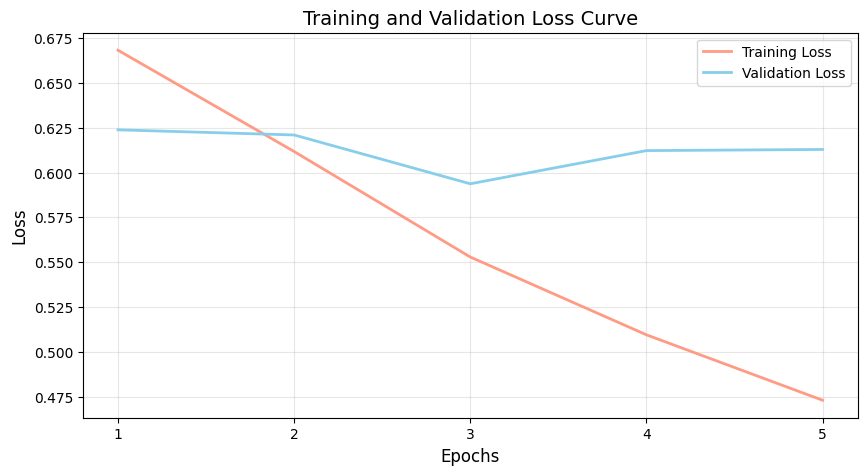

Test Set Performance:
              precision    recall  f1-score   support

    Negative       1.00      0.50      0.66      1821
    Positive       0.00      1.00      0.00         0

    accuracy                           0.50      1821
   macro avg       0.50      0.75      0.33      1821
weighted avg       1.00      0.50      0.66      1821

Overall Test Accuracy: 0.4953322350356947


In [ ]:
# 5. Loss Visualization
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='#FF9B85', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='#87CEEB', linewidth=2)
plt.title('Training and Validation Loss Curve', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(range(NUM_EPOCHS), range(1, NUM_EPOCHS+1))
plt.grid(alpha=0.3)
plt.legend()
plt.show()


# 6. Test Evaluation
def evaluate_model(model, loader):
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in loader:
      inputs = batch['input_ids'].to(device)
      mask = (batch['attention_mask'] == 0).to(device)
      labels = torch.argmax(batch['label'].to(device), dim=1)

      outputs = model(inputs, src_key_padding_mask=mask)
      preds = torch.argmax(outputs, dim=1)

      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())
  report = classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'], zero_division=1)
  accuracy = np.mean(np.array(all_preds) == np.array(all_labels))  # Calculate accuracy
  print(report)
  return accuracy

print("Test Set Performance:")
accuracy_1=evaluate_model(model_1, test_loader)
print(f"Overall Test Accuracy: {accuracy_1}")

1. Now replace the custom transformer encoder module in your transformer model with
nn.TrasformerEncoderLayer() and train the model again. Show the variation of training
and validation losses (note: use the same number of encoder layers and hidden state
dimension of each layer as in the previous case).   
2. Report the performance of the trained model using nn.TransformerEncoderLayer() on
the test (accuracy, precision, recall).

In [ ]:
# Transformer Model with PyTorch's Encoder
class TransformerClassifierWithEnc(nn.Module):
  def __init__(self, vocab_size, d_model=16, nhead=4, num_layers=1,
              dim_feedforward=16, num_classes=2, dropout=0.5, max_len=5000):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoder = PositionalEncoding(d_model, max_len)
    self.dropout_embed = nn.Dropout(dropout)

    # Built-in transformer components
    encoder_layer = nn.TransformerEncoderLayer(
        d_model=d_model,
        nhead=nhead,
        dim_feedforward=dim_feedforward,
        dropout=dropout,
        batch_first=True
    )
    self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    self.classifier = nn.Linear(d_model, num_classes)
    self.d_model = d_model

  def forward(self, src, src_key_padding_mask=None):
    # Input shape: (batch_size, seq_len)
    src = self.embedding(src) * math.sqrt(self.d_model)
    src = self.pos_encoder(src)
    src = self.dropout_embed(src)

    output = self.encoder(src, src_key_padding_mask=src_key_padding_mask)

    # Average pooling and classification
    output = output[:,0,:]  # (batch_size, d_model)
    return self.classifier(output)


# Training Setup with Correct Dimensions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(tokenizer.vocab)

model_2 = TransformerClassifierWithEnc(
  vocab_size=vocab_size,
  d_model=16,
  nhead=4,
  num_layers=1,
  dim_feedforward=16,
  num_classes=2,
  dropout=0.5
).to(device)


In [ ]:
optimizer = optim.Adam(model_2.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training Execution
NUM_EPOCHS = 5
train_losses_2 = []
val_losses_2 = []

print("Training Built-in Transformer...")
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model_2, train_loader, optimizer, criterion)
    val_loss = validate(model_2, val_loader, criterion)

    train_losses_2.append(train_loss)
    val_losses_2.append(val_loss)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}\n')



Training Built-in Transformer...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 1/5
Train Loss: 0.6895 | Val Loss: 0.6984

Epoch 2/5
Train Loss: 0.6855 | Val Loss: 0.6971

Epoch 3/5
Train Loss: 0.6811 | Val Loss: 0.6874

Epoch 4/5
Train Loss: 0.6721 | Val Loss: 0.6661

Epoch 5/5
Train Loss: 0.6625 | Val Loss: 0.6514



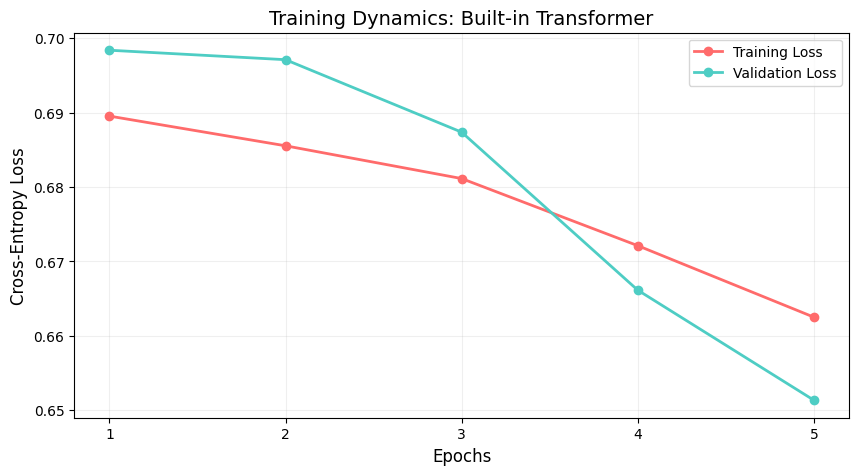


Built-in Transformer Test Performance:
              precision    recall  f1-score   support

    Negative       1.00      0.48      0.65      1821
    Positive       0.00      1.00      0.00         0

    accuracy                           0.48      1821
   macro avg       0.50      0.74      0.33      1821
weighted avg       1.00      0.48      0.65      1821

Overall Test Accuracy: 0.48215266337177376


In [ ]:
# Loss Visualization
plt.figure(figsize=(10, 5))
plt.plot(train_losses_2, '-o', label='Training Loss', color='#FF6B6B', linewidth=2)
plt.plot(val_losses_2, '-o', label='Validation Loss', color='#4ECDC4', linewidth=2)
plt.title('Training Dynamics: Built-in Transformer', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Cross-Entropy Loss', fontsize=12)
plt.xticks(range(NUM_EPOCHS), labels=range(1, NUM_EPOCHS+1))
plt.grid(alpha=0.2)
plt.legend()
plt.show()


print("\nBuilt-in Transformer Test Performance:")
test_acc_2 = evaluate_model(model_2, test_loader)
print(f"Overall Test Accuracy: {test_acc_2}")

1. Perform transfer learning by using the BERT encoder as a pre-trained encoder and train a
linear layer on the encoder representations (as done in the class tutorial). Show the
training and validation losses for the transfer learning model.   
2. Report the test set performance obtained with the above transfer learning.

In [ ]:
from transformers import BertModel, BertTokenizer

# BERT Classifier Model
class BERTClassifier(nn.Module):
  def __init__(self, num_classes=2):
    super().__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.classifier = nn.Linear(768, num_classes)  # BERT base hidden size is 768

    # Freeze BERT parameters
    for param in self.bert.parameters():
      param.requires_grad = False

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    pooled_output = outputs.pooler_output  # [CLS] token representation
    return self.classifier(pooled_output)

# Model Initialization
bert_model = BERTClassifier().to(device)
bert_optimizer = optim.Adam(bert_model.parameters(), lr=1e-3)
bert_criterion = nn.CrossEntropyLoss()


In [ ]:
# Training Loop for BERT
def train_bert_epoch(model, loader, optimizer, criterion):
  model.train()
  total_loss = 0
  for batch in loader:
    optimizer.zero_grad()

    inputs = batch['input_ids'].to(device)
    masks = batch['attention_mask'].to(device)
    labels = torch.argmax(batch['label'].to(device), dim=1)

    outputs = model(inputs, attention_mask=masks)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss / len(loader)

def validate_bert(model, loader, criterion):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for batch in loader:
      inputs = batch['input_ids'].to(device)
      masks = batch['attention_mask'].to(device)
      labels = torch.argmax(batch['label'].to(device), dim=1)

      outputs = model(inputs, attention_mask=masks)
      loss = criterion(outputs, labels)
      total_loss += loss.item()
  return total_loss / len(loader)

# Training Execution
bert_train_losses = []
bert_val_losses = []
NUM_EPOCHS = 5

print("Training BERT Classifier...")
for epoch in range(NUM_EPOCHS):
  train_loss = train_bert_epoch(bert_model, train_loader, bert_optimizer, bert_criterion)
  val_loss = validate_bert(bert_model, val_loader, bert_criterion)

  bert_train_losses.append(train_loss)
  bert_val_losses.append(val_loss)

  print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
  print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}\n')


Training BERT Classifier...
Epoch 1/5
Train Loss: 0.5833 | Val Loss: 0.5630

Epoch 2/5
Train Loss: 0.5281 | Val Loss: 0.5284

Epoch 3/5
Train Loss: 0.5191 | Val Loss: 0.5283

Epoch 4/5
Train Loss: 0.5120 | Val Loss: 0.5155

Epoch 5/5
Train Loss: 0.5091 | Val Loss: 0.5145



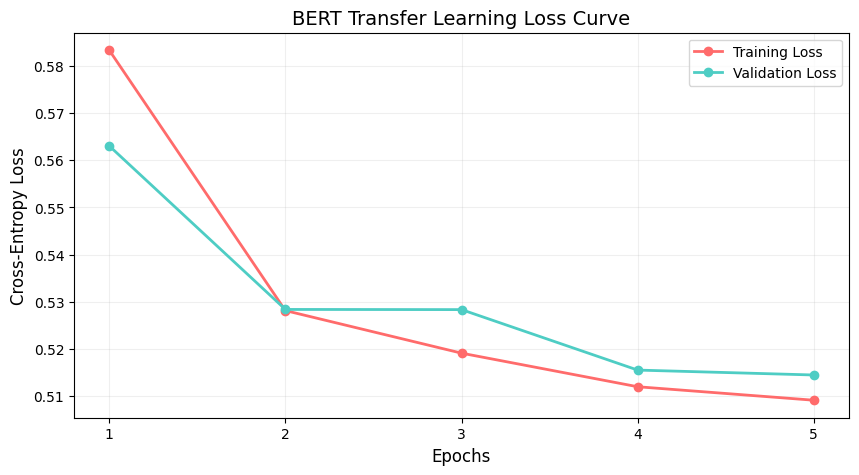


BERT Test Performance:
              precision    recall  f1-score   support

    Negative       1.00      0.56      0.71      1821
    Positive       0.00      1.00      0.00         0

    accuracy                           0.56      1821
   macro avg       0.50      0.78      0.36      1821
weighted avg       1.00      0.56      0.71      1821

Overall Test Accuracy: 0.5563


In [ ]:
# Loss Visualization
plt.figure(figsize=(10, 5))
plt.plot(bert_train_losses, '-o', label='Training Loss', color='#FF6B6B', linewidth=2)
plt.plot(bert_val_losses, '-o', label='Validation Loss', color='#4ECDC4', linewidth=2)
plt.title('BERT Transfer Learning Loss Curve', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Cross-Entropy Loss', fontsize=12)
plt.xticks(range(NUM_EPOCHS), labels=range(1, NUM_EPOCHS+1))
plt.grid(alpha=0.2)
plt.legend()
plt.show()

# BERT Evaluation
def evaluate_bert(model, loader):
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in loader:
      inputs = batch['input_ids'].to(device)
      masks = batch['attention_mask'].to(device)
      labels = torch.argmax(batch['label'].to(device), dim=1)

      outputs = model(inputs, attention_mask=masks)
      preds = torch.argmax(outputs, dim=1)

      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'],zero_division=1))
  return np.mean(np.array(all_preds) == np.array(all_labels))

print("\nBERT Test Performance:")
bert_test_acc = evaluate_bert(bert_model, test_loader)
print(f"Overall Test Accuracy: {bert_test_acc:.4f}")

Show a summary of all models and summarize insights.  

In [ ]:
# Custom Transformer Summary
print("Custom Transformer Summary:")
input_size = (32, 64)  # Batch size, sequence length
summary(model_1, input_size=input_size, dtypes=[torch.long])


Custom Transformer Summary:


Layer (type:depth-idx)                   Output Shape              Param #
TransformerClassifier                    [32, 2]                   --
├─Embedding: 1-1                         [32, 64, 16]              488,352
├─PositionalEncoding: 1-2                [32, 64, 16]              --
├─Dropout: 1-3                           [32, 64, 16]              --
├─ModuleList: 1-4                        --                        --
│    └─TransformerEncoderLayer: 2-1      [64, 32, 16]              --
│    │    └─MultiheadAttention: 3-1      [64, 32, 16]              1,088
│    │    └─Dropout: 3-2                 [64, 32, 16]              --
│    │    └─LayerNorm: 3-3               [64, 32, 16]              32
│    │    └─Linear: 3-4                  [64, 32, 16]              272
│    │    └─ReLU: 3-5                    [64, 32, 16]              --
│    │    └─Dropout: 3-6                 [64, 32, 16]              --
│    │    └─Linear: 3-7                  [64, 32, 16]              272
│    

In [ ]:
# Built-in Transformer Summary
print("\nBuilt-in Transformer Summary:")
summary(model= model_2, input_size=(32, 64), dtypes=[torch.long])



Built-in Transformer Summary:


Layer (type:depth-idx)                        Output Shape              Param #
TransformerClassifierWithEnc                  [32, 2]                   --
├─Embedding: 1-1                              [32, 64, 16]              488,352
├─PositionalEncoding: 1-2                     [32, 64, 16]              --
├─Dropout: 1-3                                [32, 64, 16]              --
├─TransformerEncoder: 1-4                     [32, 64, 16]              --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [32, 64, 16]              1,696
├─Linear: 1-5                                 [32, 2]                   34
Total params: 490,082
Trainable params: 490,082
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 15.65
Input size (MB): 0.02
Forward/backward pass size (MB): 1.31
Params size (MB): 1.96
Estimated Total Size (MB): 3.28

In [ ]:
# BERT Model Summary
print("\nBERT Model Summary:")
summary(bert_model, input_data=[torch.randint(0, 100, (32, 64)).to(device), torch.ones(32, 64).to(device)])


BERT Model Summary:


Layer (type:depth-idx)                                       Output Shape              Param #
BERTClassifier                                               [32, 2]                   --
├─BertModel: 1-1                                             [32, 768]                 --
│    └─BertEmbeddings: 2-1                                   [32, 64, 768]             --
│    │    └─Embedding: 3-1                                   [32, 64, 768]             (23,440,896)
│    │    └─Embedding: 3-2                                   [32, 64, 768]             (1,536)
│    │    └─Embedding: 3-3                                   [1, 64, 768]              (393,216)
│    │    └─LayerNorm: 3-4                                   [32, 64, 768]             (1,536)
│    │    └─Dropout: 3-5                                     [32, 64, 768]             --
│    └─BertEncoder: 2-2                                      [32, 64, 768]             --
│    │    └─ModuleList: 3-6                                  --     

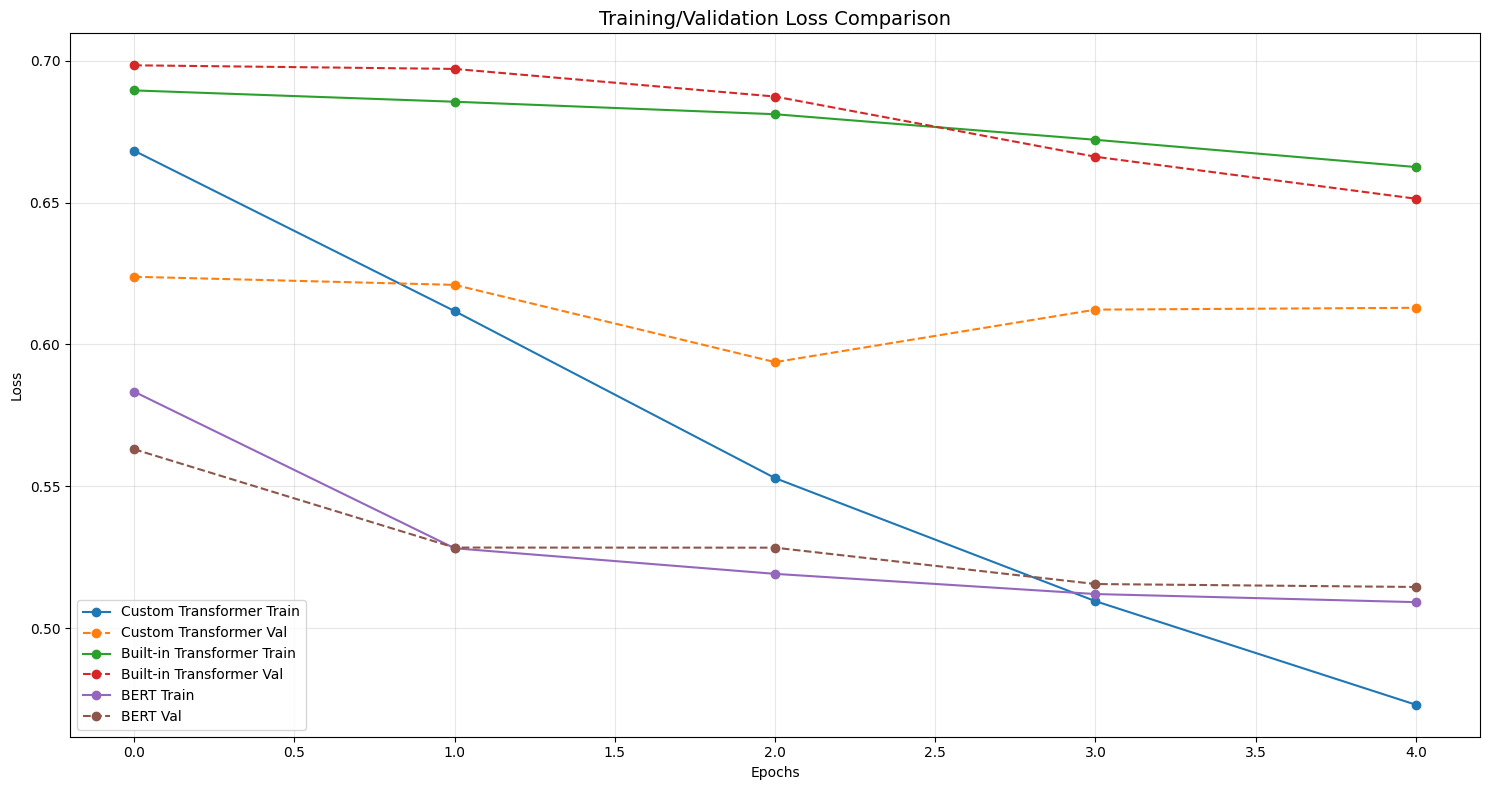

In [ ]:
def plot_combined_metrics(models_dict):
  fig, (ax1) = plt.subplots(1, 1, figsize=(15, 8))

  # Loss Plot
  for model_name, metrics in models_dict.items():
      ax1.plot(metrics['train_loss'], '-o', label=f'{model_name} Train')
      ax1.plot(metrics['val_loss'], '--o', label=f'{model_name} Val')
  ax1.set_title('Training/Validation Loss Comparison', fontsize=14)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()
  ax1.grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

# Metrics Dictionary
models_metrics = {
    'Custom Transformer': {
        'train_loss':train_losses,
        'val_loss': val_losses,

    },
    'Built-in Transformer': {
        'train_loss': train_losses_2,
        'val_loss':val_losses_2,

    },
    'BERT': {
        'train_loss': bert_train_losses,
        'val_loss': bert_val_losses,
    }
}

plot_combined_metrics(models_metrics)

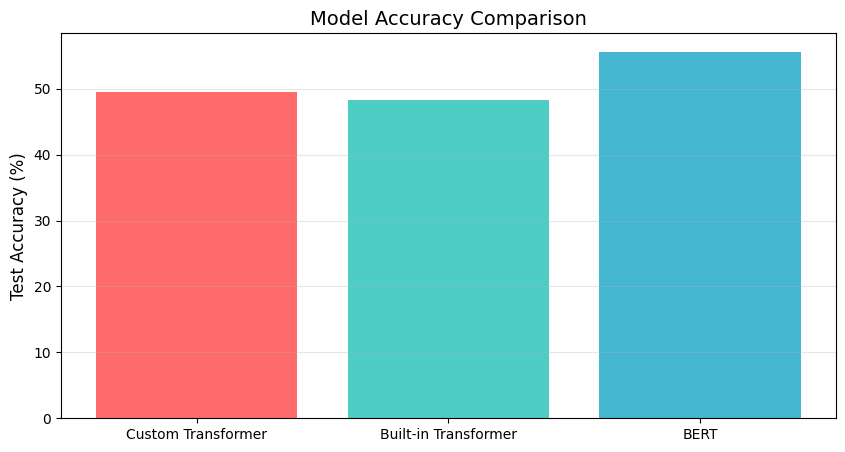

In [ ]:
# Accuracy Comparison Plot
models = ['Custom Transformer', 'Built-in Transformer', 'BERT']
accuracies = [accuracy_1*100, test_acc_2*100, bert_test_acc*100]  # Extract accuracy from classification report

plt.figure(figsize=(10,5))
bars = plt.bar(models, accuracies, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Model Accuracy Comparison', fontsize=14)
plt.ylabel('Test Accuracy (%)', fontsize=12)

plt.grid(axis='y', alpha=0.3)

plt.show()